In [1]:
import os
import csv
import pymysql as mc 
import time
import webbrowser
import sys
from sklearn.cluster import KMeans
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.preprocessing import scale
import matplotlib as mpl
mpl.rc('figure',figsize=[12,8])
from sqlalchemy import create_engine
from sqlalchemy.types import VARCHAR
from sklearn.tree import DecisionTreeClassifier
import getpass
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
font = {'family':'normal','size':16}
mpl.rc('font',**font)

In [3]:
#credentials
user='akashgoyal'
host='stromberg.cs.uchicago.edu'
db_name = 'mlb_practicum'
pw = getpass.getpass()

········


In [42]:
cnx2 = create_engine('mysql+pymysql://'+user+':'+pw+'@'+host+':3306/'+db_name,echo=False)
cnx = mc.connect(user=user,password=pw,
                 host=host,db=db_name,port=3306)

In [95]:
query = """SELECT pitcherID, COUNT(*),lastName FROM Pitch2 INNER JOIN
            Distinct_Players dp ON Pitch2.pitcherID = dp.playerID
            INNER JOIN Game ON Game.gameID = Pitch2.gameID WHERE YEAR(gameDate)!=2016
            GROUP BY pitcherID
            HAVING COUNT(*)>18000"""
distinct_player_df = pd.read_sql_query(query,cnx)

In [10]:
a = create_predictions(distinct_player_df.loc[0,'pitcherID'])
clf = LogisticRegression()
lgt_params = {'C':[0.50,1.0,1.5,2.0,5],'penalty':['l1','l2']}
gridObj = GridSearchCV(clf,lgt_params, cv=5)
gridObj.fit(a.X,a.Y)

In [41]:
X = np.linspace(10,20,6)
nn = MLPClassifier()
nn_params = {'hidden_layer_sizes':[(10,),(12,),(14,),(16,),(18,),(20,)]}
gridObj2 = GridSearchCV(nn,nn_params,cv=3)
gridObj2.fit(a.X,a.Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(10, 10), (12, 12), (14, 14), (16, 16), (18, 18), (20, 20)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
#I used this from Jae Hwang
def nn_validation_curve(X, y, param_range):
    clf = MLPClassifier()
    train_scores, test_scores = validation_curve(
        estimator=clf, X=X, y=y, param_name='hidden_layer_sizes', 
        param_range=param_range, cv=5,
        scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title('Validation Curve with Neural Network')
    plt.xlabel('Number of Hidden Nodes')
    plt.ylabel('Score')
    lw=2
    
    param_range = [i[0] for i in param_range]
    plt.plot(param_range, train_scores_mean, label='Training Score',
        color='darkorange', lw=lw, marker='o')
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.2,
        color='darkorange', lw=lw)
    plt.plot(param_range, test_scores_mean, label='Cross-Validation Score',
        color='navy', lw=lw, marker='o')
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.2,
        color='navy', lw=lw)
    plt.plot(param_range,np.full(len(param_range),0.4),label='Naiive Score')
    plt.legend(loc='best')
    return plt

In [58]:
#I used this from Jae Hwang
def logit_validation_curve(X, y, param_range):
    clf = LogisticRegression()
    train_scores, test_scores = validation_curve(
        estimator=clf, X=X, y=y, param_name='C', 
        param_range=param_range, cv=5,
        scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title('Validation Curve with Logistic Regression')
    plt.xlabel('C- Regularization Parameter')
    plt.ylabel('Score')
    lw=2
    plt.plot(param_range, train_scores_mean, label='Training Score',
        color='darkorange', lw=lw, marker='o')
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.2,
        color='darkorange', lw=lw)
    plt.plot(param_range, test_scores_mean, label='Cross-Validation Score',
        color='navy', lw=lw, marker='o')
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.2,
        color='navy', lw=lw)
    plt.plot(param_range,np.full(len(param_range),0.4),label='Naiive Score')
    plt.legend(loc='best')
    return plt

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


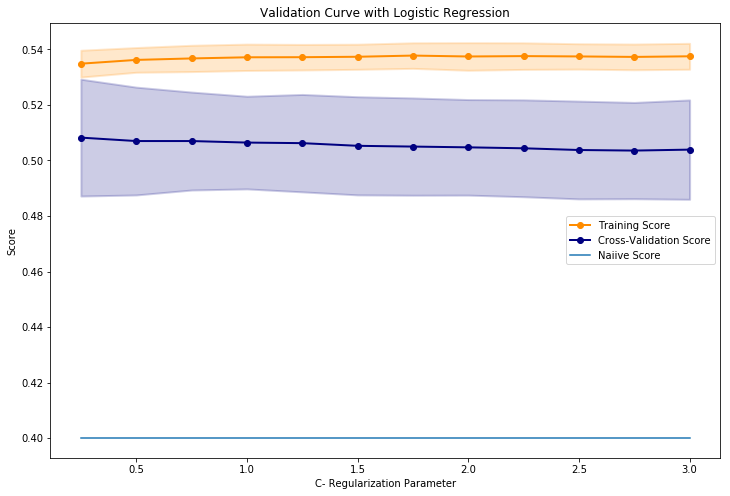

In [59]:
logit_validation_curve(a.X,a.Y,np.linspace(0.25,3,12))

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


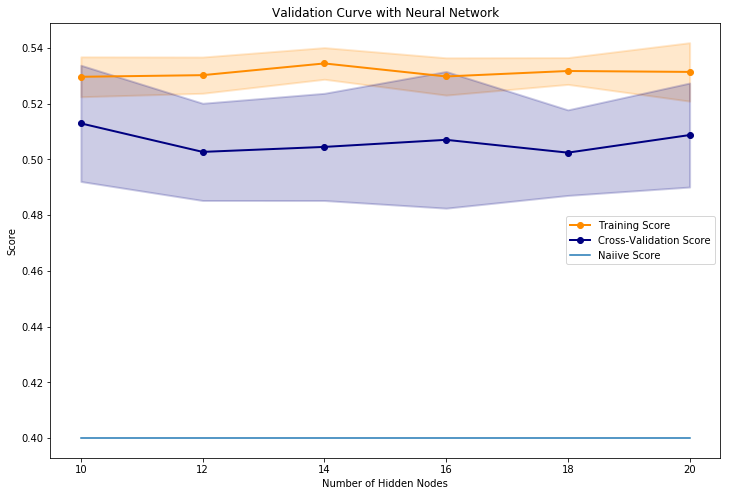

In [56]:
tree_validation_curve(a.X,a.Y,[(10,),(12,),(14,),(16,),(18,),(20,)])

In [62]:
player = distinct_player_df.loc[0,'pitcherID']
a = create_predictions(player)

if 4==5:
    for i in range(len(distinct_player_df)):
        player = distinct_player_df.loc[i,'pitcherID']
        print (f'stats for {distinct_player_df.loc[i,"lastName"]}')
        a = create_predictions(player)
        headers = a.column_names
        coef_df = pd.DataFrame(a.coefficients,columns=headers)
        abs_df = coef_df.abs()
        print(abs_df.sum(axis=0).sort_values()[-30:])

that took 2.832540988922119 seconds
150359
logistic regression score was 0.5213230705221552
---------------------------------------------------------


In [96]:
class create_predictions:
    def __init__(self,playerID):
        self.playerID = playerID
        #print ('about to run sql query')
        self.run_sql_query()
        #print ('finished query, now preprocessing the data')
        self.preprocess_data()
        #print ('done preprocessing data, now create decision tree')
        self.dt_score = self.create_decision_tree()
        #print ('finished creating the decision tree, now creating neural net')
        self.nn_score = self.create_neural_network()
        #print ('finished creating nn, now creating logistic regression')
        self.logit_score,self.coefficients,self.intercept,self.parameters = self.create_logit_reg()
        #print ('finished logit score, now getting plurality value')
        self.pv = self.plurality_value()
        
        print (self.playerID)
        #print(f'naive score was: {self.pv}')
        #print(f'decision tree score was: {self.dt_score}')
        #print(f'nn score was {self.nn_score}')
        print(f'logistic regression score was {self.logit_score}')
        #print('end ------------------------------------------------------')
        print ('---------------------------------------------------------')
    def plurality_value(self):
        print (self.Y_oos.value_counts(normalize=True))
        return self.Y_oos.value_counts(normalize=True).iloc[0]
    
    def create_logit_reg(self):
        clf2 = LogisticRegression(penalty='l1')
        clf2.fit(self.X,self.Y)
        return clf2.score(self.X_oos,self.Y_oos),clf2.coef_,clf2.intercept_,clf2.get_params()
        
    def create_neural_network(self):
        avg_nodes = int((self.X.shape[1]+8)/2)
        clf = MLPClassifier(solver='adam',alpha=0.001,hidden_layer_sizes=(avg_nodes,),random_state=1)
        clf.fit(self.X,self.Y)
        return clf.score(self.X_oos,self.Y_oos)
        
    def create_decision_tree(self):
        dt = DecisionTreeClassifier(criterion='entropy',min_impurity_decrease=0.01)
        dt.fit(self.X,self.Y)
        return dt.score(self.X_oos,self.Y_oos)
    
    def preprocess_data(self):
        start = time.time()
        
        def platoon_advantage(df):
            if df.loc['batterHand'] == df.loc['pitcherHand']:
                return 1
            else:
                return 0
        def get_current_lead(df):
            homeLead = df.loc['home_team_runs']-df.loc['away_team_runs']
            if df.loc['curr_inn']*2%2==1:
                return homeLead
            else:
                return -homeLead

        def advantageous_runner(df):
            if not df.loc['firstBaseRunner'] or df.loc['secondBaseRunner']:
                return 0
            else:
                return 1
                
        c_df = self.df.copy()
        
        c_df['batPosition'] = c_df['batPosition'].fillna(value=9) #override pinch hitters w/ 7th spot
        c_df['advantage_runner'] = c_df.apply(advantageous_runner,axis=1)
        c_df['platoon_advantage'] = c_df.apply(platoon_advantage,axis=1)
        c_df['current_lead_deficit'] = c_df.apply(get_current_lead,axis=1)
        c_df['count'] = c_df['balls'].map(str)+c_df['strikes'].map(str)
        c_df = pd.get_dummies(c_df,columns=['count']) #create 12 dummy variables for count type
        
        #now that we're done applying stuff eliminate the bad columns
        dropped_columns = ['pitcherID','batterHand','pitcherHand','home_team_runs','away_team_runs',
                          'firstBaseRunner','secondBaseRunner','the_event','balls','strikes']
        c_df = c_df.drop(columns=dropped_columns)
        print (f'that took {time.time()-start} seconds')
        
        #randomize the data 
        '''
        shuffled_data = shuffle(c_df)
        first_half = int(shuffled_data.shape[0]/2)
        train_data = shuffled_data.iloc[:first_half]
        test_data = shuffled_data.iloc[first_half:]
        self.X = train_data.drop(columns=['akash'])
        self.Y = train_data['akash']
        self.X_oos = test_data.drop(columns=['akash'])
        self.Y_oos = test_data['akash']
        x_headers = self.X.columns.values
        '''
        
        self.X = c_df.drop(columns=['akash'])
        self.Y = c_df['akash']
        self.column_names = self.X.columns.values
        #fill in NaN values with the mean for each column. Probably not the greatest method
        #because of survivorship but not many options at this point
        imp = Imputer(strategy='mean') 
        self.X = imp.fit_transform(self.X)
        self.X, self.X_oos,self.Y,self.Y_oos = train_test_split(self.X,self.Y,test_size=0.33)
        #self.X = pd.DataFrame(self.X,columns=x_headers) #imputer transforms it to numpy
        #imp2 = Imputer(strategy='mean')
        #self.X_oos = imp2.fit_transform(self.X_oos)
        #self.X_oos = pd.DataFrame(self.X_oos,columns=x_headers) 
    
    def run_sql_query(self):
        rel_cols = ['Pitch2.pitcherID','Pitch2.batterHand','Pitch2.pitcherHand','the_event','akash','curr_inn','balls',
            'strikes','cumulativePitches','timesFaced','home_team_runs','away_team_runs',
            'outs','firstBaseRunner','secondBaseRunner',
            
            'swing_four_seam_rate',
            'whiff_four_seam_rate','ball_four_seam_rate','whiff_slider_rate',
            'swing_slider_rate','ball_slider_rate','whiff_two_seam_rate',
            'swing_two_seam_rate','ball_two_seam_rate','whiff_change_up_rate',
            'swing_change_up_rate','ball_change_up_rate','whiff_knuckleball_rate',
            'swing_knuckleball_rate','ball_knuckleball_rate','whiff_curve_rate',
            'swing_curve_rate','ball_curve_rate','whiff_cutter_rate','ball_cutter_rate',
            'swing_cutter_rate', 
            
            #distribution of pitches seen by the team and by the individual in current game
             'psfg.pct_four_seam_team','psfg.pct_curve_team','psfg.pct_slider_team',
             'psfg.pct_two_seam_team','psfg.pct_cutter_team',
             'psfg.pct_knuckleball_team','psfg.pct_sinker_team','psfg.pct_change_up_team','psfg.pct_four_seam_ind',
             'psfg.pct_curve_ind','psfg.pct_slider_ind','psfg.pct_two_seam_ind','psfg.pct_cutter_ind',
             'psfg.pct_knuckleball_ind','psfg.pct_sinker_ind','psfg.pct_change_up_ind',
            
             #does leverage play a role?
             'win_probability','leverage',
            
             #batter run expectancy
             '100_avg','300_avg','500_avg','1000_avg','2000_avg',
              
              
              #in-inning distribution of pitches seen (the original mistake I made that is ok)
              'inn.pct_four_seam_ind AS AB_four_seam','inn.pct_curve_ind AS AB_curve_team',
              'inn.pct_slider_ind AS AB_slider','inn.pct_two_seam_ind AS AB_two_seam',
              'inn.pct_cutter_ind AS AB_cutter','inn.pct_knuckleball_ind AS AB_knuckleball',
              'inn.pct_sinker_ind AS AB_sinker','inn.pct_change_up_ind AS AB_change_up',
              
             #batter percentages pitches seen
            'batter_change_up_pct_seen','batter_curve_pct_seen','batter_cutter_pct_seen',
            'batter_four_seam_pct_seen','batter_knuckleball_pct_seen','batter_sinker_pct_seen',
            'batter_slider_pct_seen','batter_two_seam_pct_seen',
            
            #pitcher % pitches thrown to this point
            'pitcher_change_up_pct_thrown','pitcher_curve_pct_thrown',
            'pitcher_cutter_pct_thrown','pitcher_four_seam_pct_thrown',
            'pitcher_knuckleball_pct_thrown','pitcher_sinker_pct_thrown',
            'pitcher_slider_pct_thrown','pitcher_two_seam_pct_thrown',
                    
              #from player table
             'batPosition','hr','rbi']
        
        query = '''SELECT {} FROM Pitch2 INNER JOIN pitcher_ms_clusters_5_26_18 pms1
            ON pms1.playerID = Pitch2.pitcherID 
            INNER JOIN Distinct_Players p1 ON p1.playerID = pms1.playerID
            INNER JOIN Pitch_type_mapping pt1 ON pt1.original = Pitch2.pitchType
            INNER JOIN Game ON Game.gameID = Pitch2.gameID
            INNER JOIN batter_whiffs bw ON (bw.batterID = Pitch2.batterID
            AND bw.gameDate = Game.gameDate AND bw.pitcherHand = Pitch2.pitcherHand)
            INNER JOIN Pitches_Seen_Full_Game psfg ON 
            (psfg.gameID = Game.gameID AND psfg.pitchID = Pitch2.pitchID)
            INNER JOIN Batter_Run_Expectancy bre ON 
            (bre.playerID = Pitch2.batterID AND bre.gameID = Game.gameID)
            INNER JOIN Player ON (Player.playerID = Pitch2.batterID AND Pitch2.gameID = Player.gameID)
            INNER JOIN leverage l1 ON (l1.gameID = Pitch2.gameID AND l1.pitchID = Pitch2.pitchID)
            INNER JOIN Pitches_Seen inn ON (inn.gameID = Pitch2.gameID AND inn.pitchID = Pitch2.pitchID)
            INNER JOIN batter_classifications_5_29_18 hc5 ON (hc5.playerID = Pitch2.batterID
            AND hc5.gameDate = Game.gameDate)
            INNER JOIN pitcher_classifications_5_29_18 pc5 ON (pc5.playerID = Pitch2.pitcherID
            AND pc5.gameDate = Game.gameDate)
            WHERE Pitch2.pitcherID={} AND
            YEAR(Game.gameDate)!=2016'''.format(','.join(rel_cols),self.playerID)
        self.df = pd.read_sql_query(query,cnx)
        
        #
        #INNER JOIN pitcher_classifications_5_25_18 pc5 ON (pc5.playerID = Pitch2.pitcherID AND 
        #     pc5.gameDate = Game.gameDate)

In [12]:
query4 = """SELECT cls_bandwidth_8, AVG(change_up), AVG(curve), AVG(cutter),AVG(four_seam), AVG(knuckleball),AVG(sinker),AVG(slider), AVG(two_seam), COUNT(*)
FROM pitcher_ms_clusters_5_26_18 pms
GROUP BY cls_bandwidth_8
HAVING COUNT(*)>=10"""
df_distinct_classes = pd.read_sql_query(query4,cnx)


In [94]:
for i in range(df_distinct_classes.shape[0]):
    a = create_predictions(i)
    headers = a.column_names
    coef_df = pd.DataFrame(a.coefficients,columns=headers)
    abs_df = coef_df.abs()
    print(abs_df.sum(axis=0).sort_values()[-30:])
    if i>5:
        break

that took 11.50712537765503 seconds
0
logistic regression score was 0.6531128199726114
---------------------------------------------------------
pct_knuckleball_team              2.727940
AB_two_seam                       2.746411
pct_slider_team                   3.078008
batter_cutter_pct_seen            3.147181
count_02                          3.283412
batter_change_up_pct_seen         3.293413
AB_sinker                         3.557460
count_01                          3.751598
count_00                          3.841746
whiff_change_up_rate              3.919731
pct_two_seam_team                 3.934776
batter_slider_pct_seen            4.198639
pct_cutter_team                   4.405014
pct_change_up_team                4.595265
count_12                          4.599361
platoon_advantage                 4.705023
timesFaced                        5.137806
batter_sinker_pct_seen            5.181597
count_31                          5.559139
count_20                          5.65

that took 13.808804988861084 seconds
6
logistic regression score was 0.4153427543228298
---------------------------------------------------------
win_probability                  2.780272
pct_four_seam_ind                2.866828
100_avg                          2.883377
pct_change_up_ind                3.071069
pct_two_seam_ind                 3.347042
batter_slider_pct_seen           3.618729
pct_cutter_ind                   3.638113
pct_sinker_team                  3.641833
batter_cutter_pct_seen           4.072484
count_20                         4.337811
leverage                         4.529088
batter_change_up_pct_seen        4.753765
pitcher_two_seam_pct_thrown      4.913790
count_31                         4.942372
cumulativePitches                5.222804
batter_curve_pct_seen            5.979274
pct_curve_team                   6.854656
pct_two_seam_team                7.903243
pitcher_change_up_pct_thrown     7.956635
batter_sinker_pct_seen           8.318284
pct_change_up_

In [98]:
distinct_player_df.shape

(32, 3)

In [99]:
dt_scores = []
nn_scores = []
logit_scores = []
pv_scores = []
for i in range(distinct_player_df.shape[0]):
    player = distinct_player_df.loc[i,'pitcherID']
    resultObj = create_predictions(player)
    dt_scores.append(resultObj.dt_score)
    nn_scores.append(resultObj.nn_score)
    logit_scores.append(resultObj.logit_score)
    pv_scores.append(resultObj.pv)

that took 2.8407511711120605 seconds
sinker       0.365093
curve        0.346162
four_seam    0.214271
change_up    0.074475
Name: akash, dtype: float64
150359
logistic regression score was 0.5302683586436446
---------------------------------------------------------
that took 2.9537558555603027 seconds
four_seam    0.290497
change_up    0.232358
two_seam     0.219727
cutter       0.162390
curve        0.095028
Name: akash, dtype: float64
279824
logistic regression score was 0.3289895749799519
---------------------------------------------------------
that took 3.0187952518463135 seconds
four_seam    0.334381
slider       0.258590
sinker       0.236403
change_up    0.147850
curve        0.021991
cutter       0.000785
Name: akash, dtype: float64
282332
logistic regression score was 0.4093854309837031
---------------------------------------------------------
that took 3.5195956230163574 seconds
knuckleball    0.848678
four_seam      0.151322
Name: akash, dtype: float64
285079
logistic regr

that took 3.298204183578491 seconds
four_seam    0.312254
two_seam     0.216052
slider       0.212110
sinker       0.120387
cutter       0.102293
curve        0.036725
change_up    0.000179
Name: akash, dtype: float64
502188
logistic regression score was 0.389824435686134
---------------------------------------------------------
that took 3.1437950134277344 seconds
sinker       0.429564
cutter       0.204733
slider       0.115890
change_up    0.104808
curve        0.101052
four_seam    0.043952
Name: akash, dtype: float64
502190
logistic regression score was 0.4479714500375657
---------------------------------------------------------
that took 3.4057295322418213 seconds
four_seam    0.328982
slider       0.313664
two_seam     0.129678
curve        0.128285
change_up    0.064230
cutter       0.035161
Name: akash, dtype: float64
518516
logistic regression score was 0.427154046997389
---------------------------------------------------------
that took 3.359649896621704 seconds
two_seam    

In [100]:
temp_np = np.vstack((range(distinct_player_df.shape[0]),pv_scores,logit_scores,nn_scores,dt_scores)).transpose()

In [102]:
temp_df = pd.DataFrame(temp_np,columns=['pitcher number','pv_score','logit_score','nn_score','dt_score'])
temp_df.head()

,pitcher number,pv_score,logit_score,nn_score,dt_score
0,0.0,0.365093,0.530268,0.516954,0.481797
1,1.0,0.290497,0.328990,0.316159,0.291299
2,2.0,0.334381,0.409385,0.397016,0.391125
3,3.0,0.848678,0.865919,0.865417,0.856545
4,4.0,0.440559,0.470651,0.467260,0.444374


In [103]:
new_df = temp_df.sort_values(by=['pv_score'])
new_df.head()

,pitcher number,pv_score,logit_score,nn_score,dt_score
16,16.0,0.255302,0.398227,0.378126,0.324945
10,10.0,0.258636,0.387008,0.364324,0.308644
15,15.0,0.260654,0.375619,0.376412,0.324281
18,18.0,0.272910,0.393423,0.386806,0.376980
19,19.0,0.276650,0.346349,0.317064,0.329949


In [104]:
x_var = new_df['pv_score']
logit_improvement = new_df.apply(lambda row: row['logit_score']-row['pv_score'],axis=1)
nn_improvement = new_df.apply(lambda row: row['nn_score']-row['pv_score'],axis=1)
dt_improvement = new_df.apply(lambda row: row['dt_score']-row['pv_score'],axis=1)

[]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


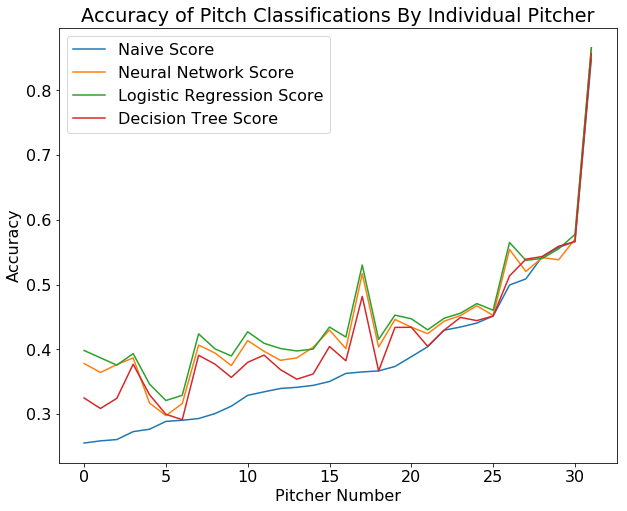

In [107]:
x_s = range(distinct_player_df.shape[0])
plt.figure(1,figsize=(10,8))
plt.title('Accuracy of Pitch Classifications By Individual Pitcher')

plt.plot(x_s,new_df['pv_score'],label='Naive Score')
plt.plot(x_s,new_df['nn_score'],label='Neural Network Score')
plt.plot(x_s,new_df['logit_score'],label='Logistic Regression Score')
plt.plot(x_s,new_df['dt_score'],label='Decision Tree Score')
#plt.plot(x_s,np.zeros(len(x_s)),c='black')

plt.xlabel('Pitcher Number') 
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.plot()

[]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


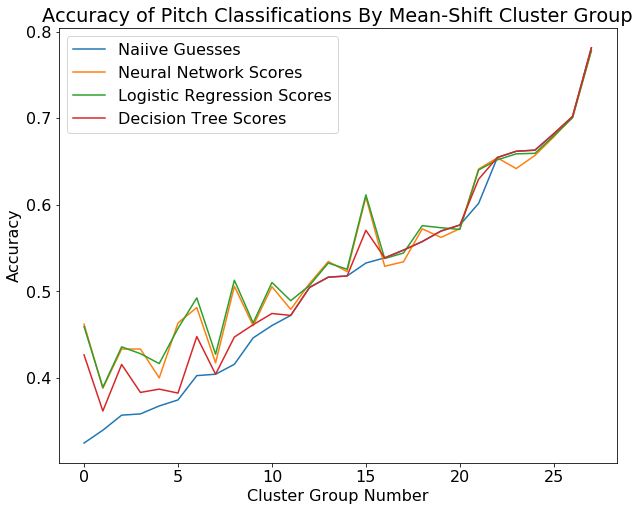

In [30]:
x_s = range(df_distinct_classes.shape[0])
plt.figure(1,figsize=(10,8))
plt.title('Accuracy of Pitch Classifications By Mean-Shift Cluster Group')

plt.plot(x_s,new_df['pv_score'],label='Naiive Guesses')
plt.plot(x_s,new_df['nn_score'],label='Neural Network Scores')
plt.plot(x_s,new_df['logit_score'],label='Logistic Regression Scores')
plt.plot(x_s,new_df['dt_score'],label='Decision Tree Scores')

'''
plt.plot(param_range, train_scores_mean, label='Training Score',
    color='darkorange', lw=lw, marker='o')
plt.fill_between(param_range, train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std, alpha=0.2,
    color='darkorange', lw=lw)
plt.plot(param_range, test_scores_mean, label='Cross-Validation Score',
    color='navy', lw=lw, marker='o')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std, alpha=0.2,
    color='navy', lw=lw)
plt.plot(param_range,np.full(len(param_range),0.4),label='Naiive Score')
'''
plt.xlabel('Cluster Group Number') 
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.plot()

In [62]:
lgt = LogisticRegression(penalty='l2',C=1)
X_train,X_test,Y_train,Y_test = train_test_split(a.X,a.Y,test_size=0.33)

In [63]:
lgt.fit(X_train,Y_train)
lgt.score(X_train,Y_train)

0.529056062314236

In [64]:
lgt.score(X_test,Y_test)

0.5346369877262326

In [65]:
predictions = lgt.predict(X_test)

In [69]:
data = np.vstack((Y_test,predictions)).transpose()
pred_df = pd.DataFrame(data,columns=['actual','predicted'])

In [71]:
correct_values = pred_df[pred_df['actual']==pred_df['predicted']]

In [114]:
pred_df.actual.value_counts(normalize=True)

sinker       0.366965
curve        0.330768
four_seam    0.220304
change_up    0.081964
Name: actual, dtype: float64

In [78]:
pred_df.predicted.value_counts(normalize=True)

sinker       0.444560
curve        0.386520
four_seam    0.159767
change_up    0.009153
Name: predicted, dtype: float64

In [117]:
sinkers = pred_df[pred_df['predicted']=='sinker']
curves = pred_df[pred_df['predicted']=='curve']
four_seam = pred_df[pred_df['predicted']=='four_seam']
change_up = pred_df[pred_df['predicted']=='change_up']

In [118]:
l = []
l.append(np.where(sinkers['actual']=='sinker',1,0).sum()/len(sinkers))
l.append(np.where(curves['actual']=='curve',1,0).sum()/len(curves))
l.append(np.where(four_seam['actual']=='four_seam',1,0).sum()/len(four_seam))
l.append(np.where(change_up['actual']=='change_up',1,0).sum()/len(change_up))

In [100]:
l

[0.645124716553288,
 0.6364779874213836,
 0.37677053824362605,
 0.0532994923857868]

In [119]:
x = [0.444,0.386,0.160,0.01]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


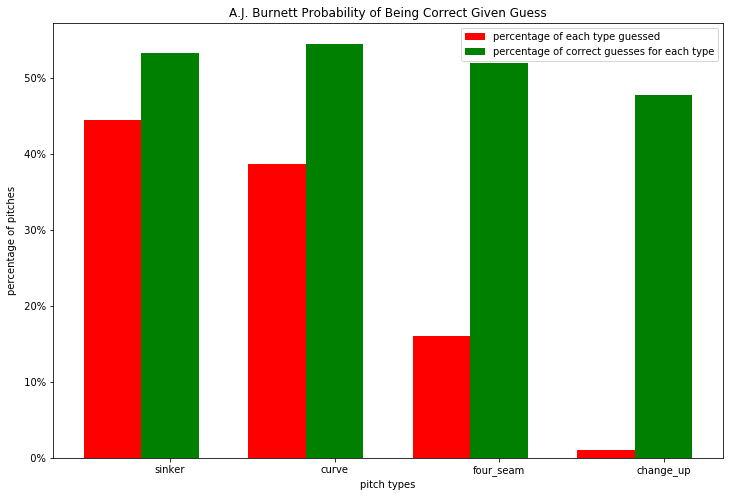

In [121]:
fig,ax = plt.subplots()
ind = np.arange(len(x))
width = 0.35 

rects1 = ax.bar(ind,x,width,color='r',label='percentage of each type guessed')
rects2 = ax.bar(ind+width,l,width,color='g',label='percentage of correct guesses for each type')

ax.set_xticks(ind+width)
ax.set_xticklabels(('sinker','curve','four_seam','change_up'))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.ylabel('percentage of pitches')
plt.xlabel('pitch types')
plt.title('A.J. Burnett Probability of Being Correct Given Guess')
plt.legend(loc='best')

In [44]:
qry = """SELECT CONCAT(firstName,' ',lastName) AS name,ROUND(change_up*100,1) AS changeup, ROUND(curve*100,1) AS curveball,
ROUND(cutter*100,1) AS cutter,ROUND(four_seam*100,1) AS four_seam,
ROUND(knuckleball*100,1) AS knuckle,ROUND(sinker*100,1) AS sinker,ROUND(slider*100,1) AS slider, 
ROUND(two_seam*100,1) AS two_seam
FROM pitcher_ms_clusters_5_26_18 pms1 INNER JOIN Distinct_Players dp1 ON dp1.playerID = pms1.playerID
WHERE cls_bandwidth_8 = 30"""
play_df = pd.read_sql_query(qry,cnx)
play_df.head()

,name,changeup,curveball,cutter,four_seam,knuckle,sinker,slider,two_seam
0,Miguel Gonzalez,15.2,10.9,0.0,38.7,0.0,0.0,17.3,18.0
1,Carlos Carrasco,16.2,11.1,0.0,37.7,0.0,0.0,16.0,19.0
2,Yunesky Maya,17.2,12.6,0.0,31.9,0.0,0.0,19.0,19.4
3,Hyun-Jin Ryu,22.0,12.7,5.0,34.1,0.0,0.0,11.5,14.6
4,Matthew Boyd,20.0,14.9,0.2,38.5,0.0,0.0,9.9,16.5


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


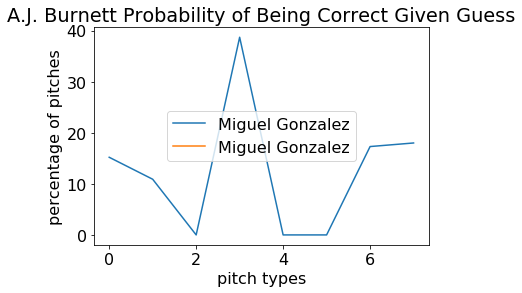

In [122]:
sample_players = play_df.iloc[:5].drop(columns=['name'])


#fig,ax = plt.subplots()
ind = np.arange(8)
width = 0.35 

plt.plot(ind,sample_players.iloc[0],width,label='Miguel Gonzalez')
#rects1 = ax.bar(ind,sample_players.iloc[0],width,label='Miguel Gonzalez')
#rects2 = ax.bar(ind+width,sample_players.iloc[1],width,label='Carlos Carrasco')
#rects3 = ax.bar(ind+2*width,sample_players.iloc[2],width,label='Yunesky Maya')
#rects4 = ax.bar(ind+3*width,sample_players.iloc[3],width,label='Hyun-Jin Ryu')
#rects5 = ax.bar(ind+4*width,sample_players.iloc[4],width,label='Matthew Boyd')

#ax.set_xticks(ind+width)
#ax.set_xticklabels(('sinker','curve','four_seam','change_up'))
#vals = ax.get_yticks()
#ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.ylabel('percentage of pitches')
plt.xlabel('pitch types')
plt.title('A.J. Burnett Probability of Being Correct Given Guess')
plt.legend(loc='best')